In [20]:
import pandas as pd
import numpy as np

#Tensor flow
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, Sequential, layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot  as plt

In [21]:
file_submission = 'data/sample_submission.csv'
file_train_data = 'data/train.csv'
file_test_data = 'data/test.csv'
df_sub = pd.read_csv(file_submission)
df_train = pd.read_csv(file_train_data)
df_test = pd.read_csv(file_test_data)

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [23]:
X = df_train['text']
X_pred = df_test['text']
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X)

X_train_token = tokenizer.texts_to_sequences(X)
X_pred_token = tokenizer.texts_to_sequences(X_pred)

In [24]:
def percentage_loss(token_words, padding_max)->str:
    """
        Test the percentage loss after padding
        Example: percentage_loss(X_token, 25) => 'After padding loss: 1.22%'
    """
    
    get_over_lenght = len([tok for tok in token_words if len(tok) >= padding_max])
    percent = get_over_lenght * 100 / len(token_words)
    
    return f'After padding loss: {percent:.2f}%'

In [25]:
percentage_loss(X_train_token, 30)

'After padding loss: 0.29%'

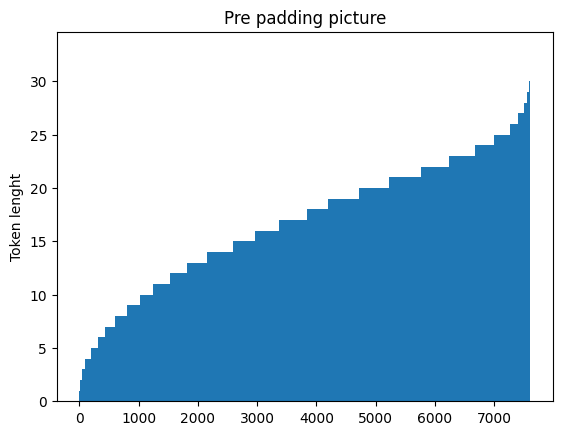

In [26]:
# Check the relevance of padding trading off performance

#Sort by ascending to make a smother graphs
X_sort = sorted(X_train_token, key=lambda x: len(x))
plt.bar(x= np.arange(1, len(X_sort) + 1), height=[len(num) for num in X_sort], width=1)
plt.title('Pre padding picture')
plt.ylabel('Token lenght')
plt.show();

In [27]:
# Cut percentage of train vs validation
percentage_cut = 30
cut_test = len(df_train) * percentage_cut // 100
cut_train = len(df_train) - cut_test

# Padding words and cut the train vs validation set
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='pre', maxlen=30)
X_pred_pad = pad_sequences(X_pred_token, dtype='float32', padding='pre')

X_train_pad = X_train_pad[:cut_train]
X_val_pad = X_train_pad[-cut_test:]

y_train = df_train['target'][:cut_train]
y_val = df_train['target'][-cut_test:]
print(f'The X train length is {len(X_train_pad)} vs X validation is {len(X_val_pad)}')

The X train length is 5330 vs X validation is 2283


In [76]:
# Initialize model and define vocabulary size
vocab_size = len(tokenizer.word_index)

def initialize_model():

    model = Sequential()
    
    model.add(layers.Embedding(
        input_dim= vocab_size + 1,
        input_length= 30, 
        output_dim = 30,
        #embeddings_regularizer= regularizers.l1(0.001),
        #activity_regularizer= regularizers.l2(0.01),
        mask_zero = True
    ))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
   
    optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [77]:
model = initialize_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 30, 30)            681030    
                                                                 
 lstm_19 (LSTM)              (None, 32)                8064      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 689127 (2.63 MB)
Trainable params: 689127 (2.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0003)
es = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

history = model.fit(
    X_train_pad, 
    y_train, 
    batch_size=50, 
    epochs=100,
    validation_data=(X_val_pad, y_val),
    callbacks = [es])

Epoch 1/100
107/107 [==============================] - 25s 228ms/step - loss: 0.1407 - accuracy: 0.9437 - val_loss: 2.4603 - val_accuracy: 0.5318
Epoch 2/100
 66/107 [=================>............] - ETA: 6s - loss: 0.1658 - accuracy: 0.9330

KeyboardInterrupt: 

In [80]:
pred_res = model.predict(X_pred_pad)

102/102 [==============================] - 4s 34ms/step


<BarContainer object of 3263 artists>

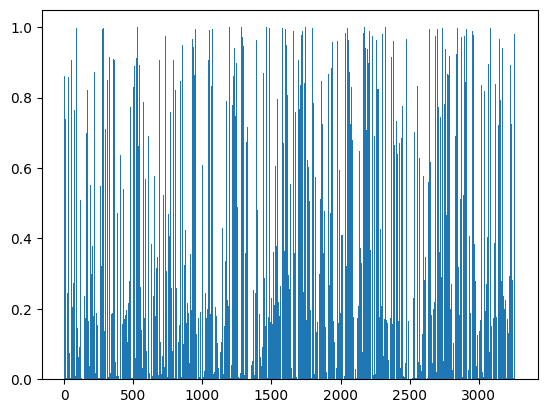

In [81]:
plt.bar(x= np.arange(1, len(pred_res) + 1), height= [float(res) for res in pred_res], width=1)

In [82]:
# Extract the loss and accuracy from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


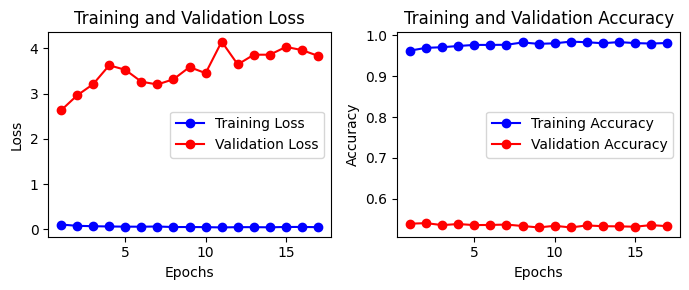

In [83]:
epochs = range(1, len(train_loss) + 1)

# Plot training & validation loss values
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [332]:
# map_res = [1 if x > 0.5 else 0 for x in pred_res ]

# df_test['target'] = map_res
# df_submit = df_test[['id','target']]
# df_submit.to_csv('data/submit_15_08_24.csv', index= False)

# pd.read_csv('data/submit_15_08_24.csv')

In [333]:
# Score was 0.7744

In [334]:
"""Drop out on early process change the loss training at the end"""

'Drop out on early process change the loss training at the end'